<a href="https://colab.research.google.com/github/neha-sharma4/ML_Lab/blob/main/BDT_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [34]:
%matplotlib inline

In [35]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
columns = [f"feature_{i}" for i in range(57)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

print("Dataset loaded successfully")
print("Shape:", df.shape)
print(df.head())


Dataset loaded successfully
Shape: (4601, 58)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       0.00       0.64       0.64        0.0       0.32       0.00   
1       0.21       0.28       0.50        0.0       0.14       0.28   
2       0.06       0.00       0.71        0.0       1.23       0.19   
3       0.00       0.00       0.00        0.0       0.63       0.00   
4       0.00       0.00       0.00        0.0       0.63       0.00   

   feature_6  feature_7  feature_8  feature_9  ...  feature_48  feature_49  \
0       0.00       0.00       0.00       0.00  ...        0.00       0.000   
1       0.21       0.07       0.00       0.94  ...        0.00       0.132   
2       0.19       0.12       0.64       0.25  ...        0.01       0.143   
3       0.31       0.63       0.31       0.63  ...        0.00       0.137   
4       0.31       0.63       0.31       0.63  ...        0.00       0.135   

   feature_50  feature_51  feature_52  feature_53  feature

In [36]:
X = df.drop('label', axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("\nTrain samples:", X_train.shape[0], " Test samples:", X_test.shape[0])


Train samples: 3450  Test samples: 1151


In [37]:
classes = np.unique(y_train)
n_classes = len(classes)
n_features = X_train.shape[1]

priors = {}
means = {}
vars_ = {}

for c in classes:
    X_c = X_train[y_train == c]
    priors[c] = X_c.shape[0] / X_train.shape[0]
    means[c] = np.mean(X_c, axis=0)
    vars_[c] = np.var(X_c, axis=0) + 1e-6

print("\nClass priors:", priors)


Class priors: {np.int64(0): 0.6060869565217392, np.int64(1): 0.3939130434782609}


In [38]:
def gaussian_likelihood(x, mean, var):
    coeff = 1.0 / np.sqrt(2.0 * np.pi * var)
    exponent = np.exp(- (x - mean)**2 / (2 * var))
    return coeff * exponent

In [39]:
def compute_posterior(x):
    posteriors = {}
    for c in classes:
        log_prior = np.log(priors[c])
        log_likelihood = np.sum(np.log(gaussian_likelihood(x, means[c], vars_[c])))
        posteriors[c] = log_prior + log_likelihood
    return posteriors



--- Results (Equal cost, MAP rule) ---
[[519 178]
 [ 23 431]]
              precision    recall  f1-score   support

    not spam       0.96      0.74      0.84       697
        spam       0.71      0.95      0.81       454

    accuracy                           0.83      1151
   macro avg       0.83      0.85      0.82      1151
weighted avg       0.86      0.83      0.83      1151



/tmp/ipython-input-759466649.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(gaussian_likelihood(x, means[c], vars_[c])))


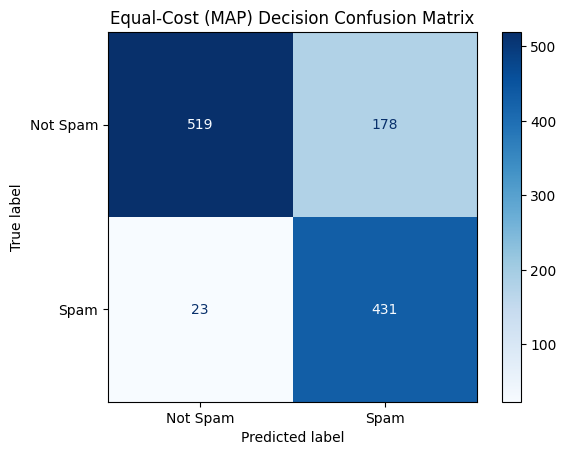

In [40]:
def predict(X):
    preds = []
    for x in X:
        post = compute_posterior(x)
        preds.append(max(post, key=post.get))
    return np.array(preds)

y_pred = predict(X_test)

print("\n--- Results (Equal cost, MAP rule) ---")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["not spam", "spam"]))

cm_equal = confusion_matrix(y_test, y_pred)
disp_equal = ConfusionMatrixDisplay(confusion_matrix=cm_equal, display_labels=["Not Spam", "Spam"])
disp_equal.plot(cmap="Blues", values_format="d")
plt.title("Equal-Cost (MAP) Decision Confusion Matrix")
plt.show()

/tmp/ipython-input-759466649.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(gaussian_likelihood(x, means[c], vars_[c])))
/tmp/ipython-input-149045050.py:14: RuntimeWarning: invalid value encountered in scalar divide
  post[c] /= total



--- Results (Cost-sensitive BDT) ---
[[520 177]
 [ 24 430]]
              precision    recall  f1-score   support

    not spam       0.96      0.75      0.84       697
        spam       0.71      0.95      0.81       454

    accuracy                           0.83      1151
   macro avg       0.83      0.85      0.82      1151
weighted avg       0.86      0.83      0.83      1151

Average Bayes Risk (Expected Loss): nan


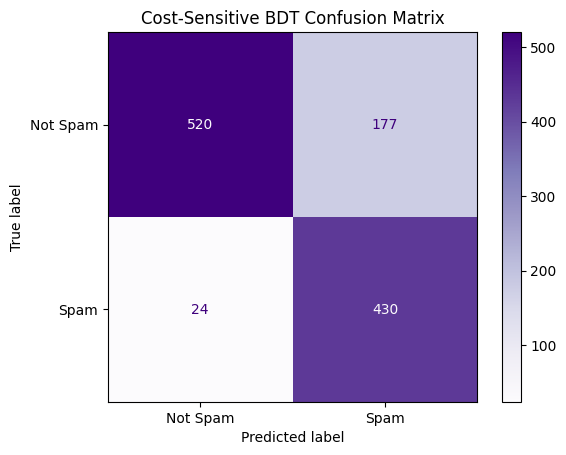

In [41]:
L = np.array([
    [0, 2],
    [5, 0],
])

def predict_with_loss(X):
    preds = []
    risks = []
    for x in X:
        post = compute_posterior(x)
        post = {c: np.exp(v) for c, v in post.items()}
        total = sum(post.values())
        for c in post:
            post[c] /= total

        expected_loss = []
        for pred_class in classes:
            loss = sum(L[int(pred_class), int(true_c)] * post[true_c] for true_c in classes)
            expected_loss.append(loss)
        pred = classes[np.argmin(expected_loss)]
        preds.append(pred)
        risks.append(min(expected_loss))
    return np.array(preds), np.mean(risks)

y_pred_cost, avg_risk = predict_with_loss(X_test)

print("\n--- Results (Cost-sensitive BDT) ---")
print(confusion_matrix(y_test, y_pred_cost))
print(classification_report(y_test, y_pred_cost, target_names=["not spam", "spam"]))
print("Average Bayes Risk (Expected Loss):", avg_risk)
cm_cost = confusion_matrix(y_test, y_pred_cost)
disp_cost = ConfusionMatrixDisplay(confusion_matrix=cm_cost, display_labels=["Not Spam", "Spam"])
disp_cost.plot(cmap="Purples", values_format="d")
plt.title("Cost-Sensitive BDT Confusion Matrix")
plt.show()

/tmp/ipython-input-759466649.py:5: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.sum(np.log(gaussian_likelihood(x, means[c], vars_[c])))
/tmp/ipython-input-1257587681.py:6: RuntimeWarning: invalid value encountered in scalar divide
  probs_spam.append(post[1] / total)


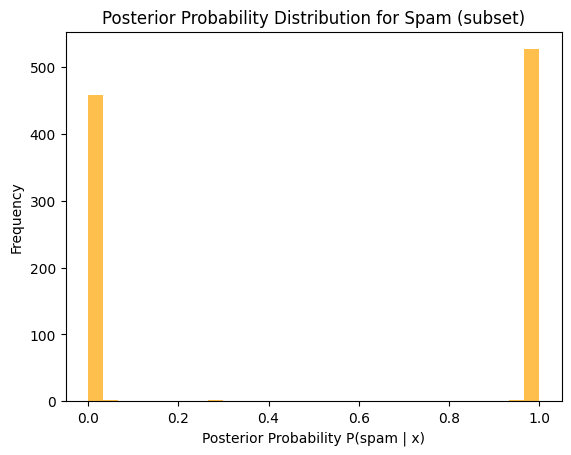

In [42]:

probs_spam = []
for x in X_test[:1000]:
    post = compute_posterior(x)
    post = {c: np.exp(v) for c, v in post.items()}
    total = sum(post.values())
    probs_spam.append(post[1] / total)

plt.hist(np.array(probs_spam), bins=30, alpha=0.7, color='orange')
plt.xlabel("Posterior Probability P(spam | x)")
plt.ylabel("Frequency")
plt.title("Posterior Probability Distribution for Spam (subset)")
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Equal-cost metrics ---
acc_equal = accuracy_score(y_test, y_pred)
prec_equal = precision_score(y_test, y_pred)
rec_equal = recall_score(y_test, y_pred)
f1_equal = f1_score(y_test, y_pred)

print("\nPerformance (Equal-Cost BDT):")
print(f"Accuracy : {acc_equal:.4f}")
print(f"Precision: {prec_equal:.4f}")
print(f"Recall   : {rec_equal:.4f}")
print(f"F1-score : {f1_equal:.4f}")

# --- Cost-sensitive metrics ---
acc_cost = accuracy_score(y_test, y_pred_cost)
prec_cost = precision_score(y_test, y_pred_cost)
rec_cost = recall_score(y_test, y_pred_cost)
f1_cost = f1_score(y_test, y_pred_cost)

print("\nPerformance (Cost-Sensitive BDT):")
print(f"Accuracy : {acc_cost:.4f}")
print(f"Precision: {prec_cost:.4f}")
print(f"Recall   : {rec_cost:.4f}")
print(f"F1-score : {f1_cost:.4f}")
print(f"Average Bayesian Risk: {avg_risk:.6f}")



Performance (Equal-Cost BDT):
Accuracy : 0.8254
Precision: 0.7077
Recall   : 0.9493
F1-score : 0.8109

Performance (Cost-Sensitive BDT):
Accuracy : 0.8254
Precision: 0.7084
Recall   : 0.9471
F1-score : 0.8106
Average Bayesian Risk: nan
